## Polynomial Chaos Kriging with gstools

The goal is to create a so called "polynomial chaos kriging" model as defined in [the paper with the same name](https://arxiv.org/abs/1502.03939). The paper outlines two methodologies: Sequential and optimal polynomial chaos kriging. We are going to discuss both. 
If digging into the source material, it is also worth reading (Adaptive spare polynomial chaos expansion based on least angle regression)[https://www.sciencedirect.com/science/article/pii/S0021999110006856] which outlines the polynomial selection step using LARS.

As an example, we use the distribution and model defined in the [example introduction](./example_introduction.ipynb) but limiting the analysis to `coordinates=1`. And we define 10 samples:

In [1]:
from chaospy.example import distribution, exponential_model

samples = distribution.sample(30, rule="sobol")
evaluations = exponential_model(samples, coordinates=1)

(samples.round(2), evaluations.round(2))

(array([[1.5 , 1.63, 1.37, 1.44, 1.73, 1.56, 1.27, 1.32, 1.6 , 1.81, 1.47,
         1.4 , 1.68, 1.53, 1.19, 1.24, 1.55, 1.7 , 1.42, 1.48, 1.87, 1.62,
         1.34, 1.3 , 1.58, 1.76, 1.45, 1.38, 1.66, 1.52],
        [0.15, 0.13, 0.18, 0.14, 0.19, 0.11, 0.16, 0.13, 0.18, 0.11, 0.16,
         0.12, 0.17, 0.14, 0.19, 0.15, 0.2 , 0.12, 0.17, 0.11, 0.16, 0.13,
         0.18, 0.12, 0.17, 0.14, 0.19, 0.13, 0.18, 0.1 ]]),
 array([1.29, 1.44, 1.15, 1.25, 1.43, 1.4 , 1.08, 1.16, 1.33, 1.62, 1.26,
        1.25, 1.42, 1.33, 0.98, 1.07, 1.27, 1.51, 1.2 , 1.33, 1.6 , 1.41,
        1.12, 1.16, 1.34, 1.53, 1.2 , 1.22, 1.39, 1.37]))

For illustration, here is contour plot of the model and samples:

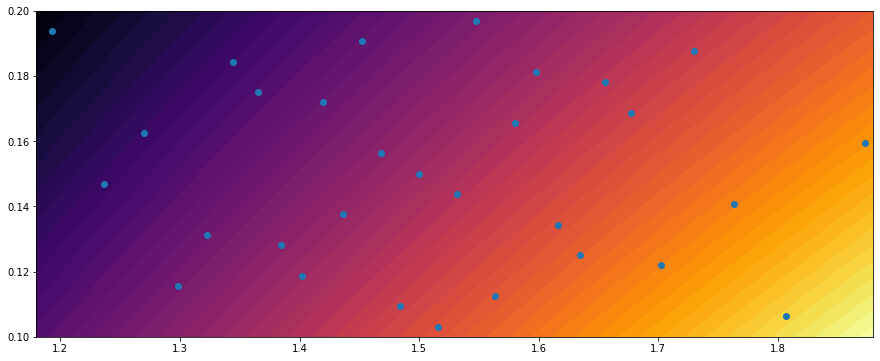

In [2]:
import numpy
from matplotlib import pyplot

pyplot.rc("figure", figsize=[15, 6])

x, y = numpy.mgrid[1.18:1.88:40j, 0.1:0.2:40j]
pyplot.contourf(x, y, exponential_model([x, y], coordinates=2), 50)
pyplot.scatter(*samples)
pyplot.show()

### Sequential polynomial chaos kriging

We are going to do this using the following steps:

* Create a pool of orthogonal polynomials using `chaospy`.
* Use `scikit-learn`'s least angular regression model to reduce the pool.
* Use `gstools` to create an universal Kriging model with the orthogonal polynomials as drift terms.

The result is what is what the paper defines as "sequential polynomial chaos kriging".

We start the work by creating a polynomial chaos expansion. Preferably something large that can be filtered down.
And as we need it for the kringing, the polynomials needs to be orthonormal. And as suggested in the regression paper, we use cross truncation. For example:

In [3]:
# NBVAL_CHECK_OUTPUT
expansion = chaospy.generate_expansion(10, distribution, normed=True, cross_truncation=0.8)

expansion[:4].round(5), expansion.shape

(polynomial([1.0, 34.64102*q1-5.19615, 5.0*q0-7.5,
             1341.64079*q1**2-402.49224*q1+29.06888]),
 (51,))

As `chaospy` does not support least angular regression, we use the [scikit-learn](https://scikit-learn.org/) implementation.
The real methodology for selecting polynomials using Lars as explained in the paper is a bit involved, so for this tutorial example we are going to simplify to use `LarsCV`, which is similar to what the paper does.

In [4]:
# NBVAL_CHECK_OUTPUT
from sklearn.linear_model import LarsCV

lars = LarsCV(fit_intercept=False, max_iter=15)
pce, coeffs = chaospy.fit_regression(
    expansion, samples, evaluations, model=lars, retall=True)
expansion_ = expansion[coeffs != 0]

pce.round(2)

polynomial(0.33*q0*q1**2+0.13*q1**2-0.96*q0*q1-0.04*q1+q0)

Note that the same coefficients can be created from the `lars` model directly, but that does not yield a fitted expansion:

In [5]:
# NBVAL_CHECK_OUTPUT
lars = LarsCV(fit_intercept=False, max_iter=15)
lars.fit(expansion(*samples).T, evaluations)
expansion_ = expansion[lars.coef_ != 0]

lars.coef_.round(6)

array([ 1.29159e+00, -3.72720e-02,  1.72198e-01,  4.72000e-04,
        0.00000e+00, -4.95700e-03,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  5.00000e-05,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00])

This resulted in a reduction of the number of polynomials:

In [6]:
print("number of expansion terms total:", len(expansion))
print("number of expansion terms included:", len(expansion_))

number of expansion terms total: 51
number of expansion terms included: 6


With the number of polynomials reduced, we can create our kriging model.
In this case we use the excellent [gstools](https://geostat-framework.readthedocs.io/) library:

In [13]:
import gstools

model = gstools.Gaussian(dim=2, var=1)
pck = gstools.krige.Universal(model, samples, evaluations, list(expansion_[1:]))
expansion_[:3]

polynomial([1.0, 34.64101615137754*q1-5.196152422706632, 5.0*q0-7.5])

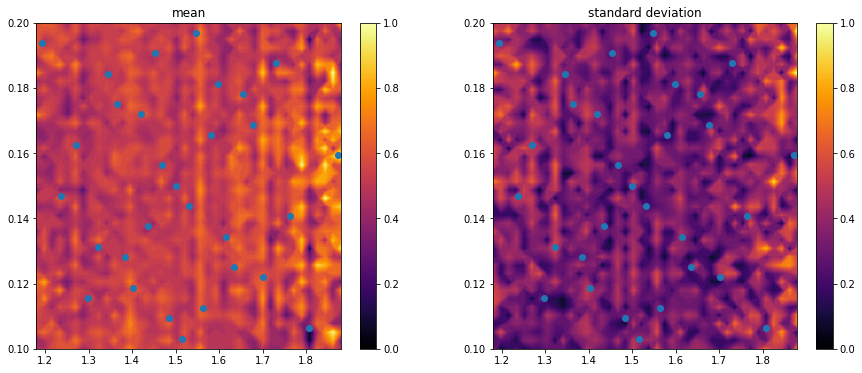

In [14]:
mean, variance = pck([x.ravel(), y.ravel()])

pyplot.subplot(121)
pyplot.contourf(x, y, mean.reshape(40, 40), 50)
pyplot.scatter(*samples)
pyplot.colorbar()
pyplot.title("mean")

pyplot.subplot(122)
pyplot.contourf(x, y, (abs(variance)**0.5).reshape(40, 40), 50)
pyplot.scatter(*samples)
pyplot.colorbar()
pyplot.title("standard deviation")

pyplot.show()

For reference, we also create a more traditional universal kriging model with linear drift.

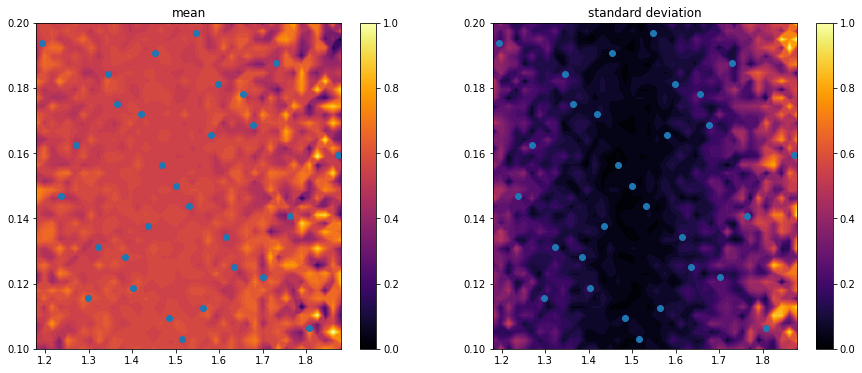

In [15]:
uk = gstools.krige.Universal(model, samples, evaluations, "linear")
mean, variance = uk([x.ravel(), y.ravel()])

pyplot.subplot(121)
pyplot.contourf(x, y, mean.reshape(40, 40), 50)
pyplot.scatter(*samples)
pyplot.colorbar()
pyplot.title("mean")

pyplot.subplot(122)
pyplot.contourf(x, y, (abs(variance)**0.5).reshape(40, 40), 50)
pyplot.scatter(*samples)
pyplot.colorbar()
pyplot.title("standard deviation")

pyplot.show()